In [258]:
#Установка необходимых библиотек
!pip install scikit-uplift==0.2.0

In [259]:
# Подключение необходимых библиотек и модулей
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings('ignore')

# Домашнее задание №4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. (опционально) построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Решение

1. Загрузка данных

In [260]:
df = pd.read_csv('data.csv', encoding='cp1251')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


**recency** -- количество месяцев с момента последней покупки \
**history** -- общая сумма совершенных покупок \
**used_discount** -- индикатор использования покупателем скидки \
**used_bogo** -- индикатор использования покупателем акции 1+1 \
**zip_code** -- класс почтового индекса (пригородный/городской/сельский) \
**is_referral** -- индикатор привлечения клиента через рассылку \
**channel** -- канал коммуникации, используемый клиентом \
**offer** -- предложения, отправленные клиенту (скидка/ 1 + 1/без предложения)\
**conversion** -- действие клиента (купил или не купил)

In [261]:
#Определяем количество пропусков. Пропусков нет.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


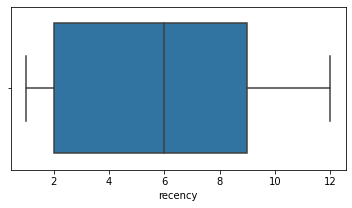

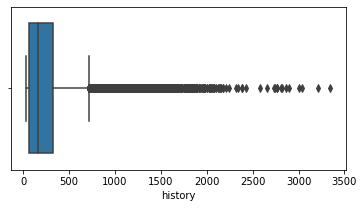

In [262]:
#Исследование количественных признаков на выбросы
for feature in ['recency', 'history']:
    plt.figure(figsize=(6, 3))
    sns.boxplot(df[feature], whis=1.5)
    plt.xlabel(feature)
    plt.show()

2. Переименование полей (conversion -> target, offer -> treatment) и приведение поля treatment к бинарному виду

In [263]:
#Переименование полей
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

#Приведение поля к бинарному виду
df['treatment'] = df['treatment'].replace({'No Offer':0, 'Buy One Get One':1, 'Discount':1})

df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


3. feature engineering

In [264]:
# Датасет для feature engineering
select = [x for x in df.columns if (x != "treatment") & (x != "target")]
X = df.loc[:, select]
X.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web


feature encording

In [265]:
#Вычислям медианное значение history по каждому значению следующих признаков
for feature in ['recency','used_discount', 'used_bogo']:
    d = X.groupby(feature, as_index=False).median()[[feature,'history']].rename(columns={
    'history': f'history encode {feature}'})
    X = X.merge(d, on=feature, how='left')
X.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,history encode recency,history encode used_discount,history encode used_bogo
0,10,142.44,1,0,Surburban,0,Phone,116.910,183.195,135.845
1,6,329.08,1,1,Rural,1,Web,145.720,183.195,183.565
2,7,180.65,0,1,Surburban,1,Web,143.435,135.980,183.565


In [266]:
#Вычислям медианное значение recency по каждому значению следующих признаков
for feature in ['used_discount', 'used_bogo', 'is_referral']:
    d = X.groupby(feature, as_index=False).median()[[feature,'recency']].rename(columns={
    'recency': f'recency encode {feature}'})
    X = X.merge(d, on=feature, how='left')
X.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,history encode recency,history encode used_discount,history encode used_bogo,recency encode used_discount,recency encode used_bogo,recency encode is_referral
0,10,142.44,1,0,Surburban,0,Phone,116.910,183.195,135.845,5,6,6
1,6,329.08,1,1,Rural,1,Web,145.720,183.195,183.565,5,5,5
2,7,180.65,0,1,Surburban,1,Web,143.435,135.980,183.565,6,5,5


In [267]:
#Собираем датасет после преобразования признаков
df = pd.concat([X, df[['treatment', 'target']]], axis=1)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,history encode recency,history encode used_discount,history encode used_bogo,recency encode used_discount,recency encode used_bogo,recency encode is_referral,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,116.910,183.195,135.845,5,6,6,1,0
1,6,329.08,1,1,Rural,1,Web,145.720,183.195,183.565,5,5,5,0,0
2,7,180.65,0,1,Surburban,1,Web,143.435,135.980,183.565,6,5,5,1,0


4. Разбиение набора данных не тренировочную и тестовую выборки

In [268]:
# Делаем разбиения по индексам
indices = df.index
indices_train, indices_test = train_test_split(indices, test_size=0.3, random_state=123)

#Заводим переменные для train и test
X_train = df.loc[indices_train, :]
y_train = df.loc[indices_train, 'target']
treat_train = df.loc[indices_train, 'treatment']

X_test = df.loc[indices_test, :]
y_test = df.loc[indices_test, 'target']
treat_test =  df.loc[indices_test, 'treatment']

#собираем категориальные признаки
cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

5. Uplift-моделирование

С помощью этого подхода оценивается эффект от коммуникации с клиентами и выбирается группа, которая наиболее подвержена влиянию.

Uplift модель оценивает чистый эффект от коммуникации, пытаясь выбрать только тех клиентов, которые совершат целевое действие только при нашем взаимодействии (убеждаемый тип). \
Модель оценивает разницу в поведении клиента при наличии воздействия и при его отсутствии.

$$Uplift = P^T - P^C = P(Y=1|W=1) - P(Y=1|W=0),$$
где $Y$ -- целевая переменная, $W$ -- флаг коммуникации



Для подсчета uplift@k%:\
-- сортируем выборку по величине предсказанного uplift, \
-- выбираем k% записей (начиная сначала),\
-- вычисляем разницу средних значений таргета $Y$ в целевой (которая получила коммуникацию $W=1$) и контрольной (которая получила не коммуникацию $W=0$) группах.

Теоретический uplift@k принимает значения от -1 (когда в целевой группе нет реакций Y=1, а в контрольной группе все клиенты имеют реакцию Y=1) до 1 (в целевой группе все клиенты откликнулись Y=1, в то время как в контрольной - ни одного случая с Y=1).


**1 способ (одна модель с признаком коммуникации (S learner))** \
принцип работы: \
-- модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака;\
-- каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0; \
-- вычитая вероятности по каждому наблюдению, получим искомы uplift.

![title](uplift4.png)

uplift@10%: 0.0000
uplift@20%: 0.3124


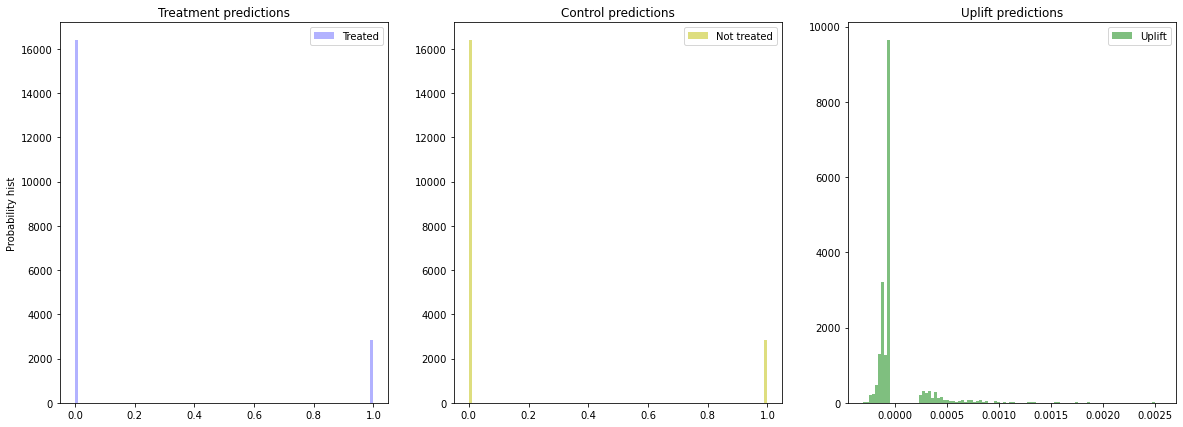

In [269]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

*Вывод:* чтобы добиться нужной реакции от клиента ($Y=1$) в ответ на коммуникацию надо брать не менее 20% клиентов.

**2 способ (модель с трансформацией таргета)** \
принцип работы: прогнозирование измененного таргета 
$$Z_i = Y_iW_i + (1-Y_i)(1-W_i),$$
где $Z_i$ -- новая целевая переменная клиента (наблюдаемая реакция клиента в результате маркетинговой кампании), \
$Y_i$ -- целевая переменная клиента (потенциальная реакция человека, если с ним была коммуникация), \
$W_i$ -- флаг коммуникации клиента, \
$i = \overline{(1,n)}$, где $n$ -- количество клиентов.

In [270]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')

uplift@10%: 1.0000
uplift@20%: 0.8390


*Вывод:* чтобы добиться нужной реакции от клиента ($Y=1$) в ответ на коммуникацию надо брать 10% клиентов.

**3 способ (две независимые модели)** \
принцип работы: \
-- строится первая модель, оценивающая вероятность выполнения целевого действия среди клиентов, с которыми мы взаимодействовали;\
-- строится вторая модель, оценивающая ту же вероятность, но среди клиентов, с которыми мы не производили коммуникацию;\
-- для каждого клиента рассчитывается разность оценок вероятностей двух моделей.

![title](uplift_2models.png)

uplift@10%: 0.0047
uplift@20%: 0.3124


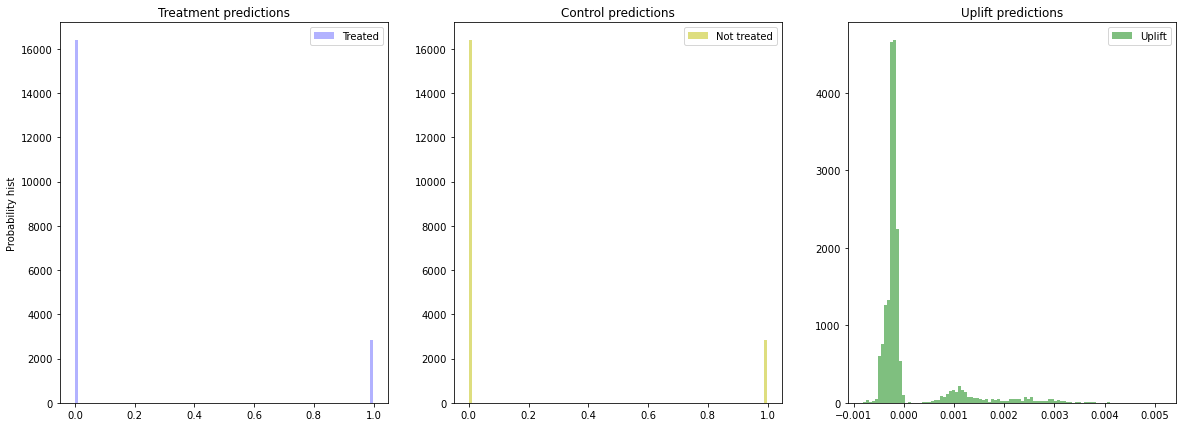

In [271]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

*Вывод:* чтобы добиться нужной реакции от клиента ($Y=1$) в ответ на коммуникацию надо брать не менее 20% клиентов.

6. Единая таблица сравнения метрик uplift@10%, uplift@20% трех моделей

In [272]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.000000,0.312437
1,ClassTransformation,1.000000,0.839000
2,TwoModels,0.004687,0.312437


**Вывод:** лучшие показатели (чистый эффект от коммуникации) у модели ClassTransformation.